In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

In [4]:
import glob
import os

pfad = "../data/tageswerte_pro_Jahr/*.csv"

dateien = glob.glob(pfad)
dfs = []
for datei in dateien:
    df_temp = pd.read_csv(datei, low_memory=False)
    df_temp["year"] = os.path.basename(datei).split("_")[2].split(".")[0]
    dfs.append(df_temp.astype({"year":int}))

df = pd.concat(dfs, ignore_index=True)

operator_name                  0
domain_name                    0
domain_id                      0
counter_site                   0
counter_site_id                0
counter_serial              1593
longitude                      0
latitude                       0
timezone                       0
iso_timestamp                  0
channels_in                26510
channels_out               26559
channels_unknown          220492
channels_all                   0
site_temperature           20642
site_rain_accumulation     20642
site_snow_accumulation     20656
year                           0
dtype: int64


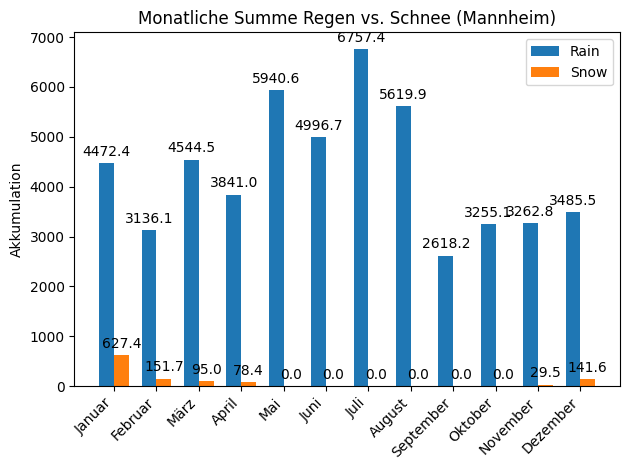

In [5]:
# Daten bereinigen

# replace various forms of 'na' with np.nan
df = df.replace(["na", "NA", "Na"], np.nan)

df_backup = df.copy()
print(df.isna().sum())
# TODO Find if temp rain and snow values are missing in a pattern or at random
# convert numeric values to corresponding dtypes
df["site_temperature"] = df["site_temperature"].astype(float)
df["site_rain_accumulation"] = df["site_rain_accumulation"].astype(float)
df["site_snow_accumulation"] = df["site_snow_accumulation"].astype(float)

# Mannheim subset, saved to file
df_ma = df[df["domain_name"] == 'Stadt Mannheim']
df_ma.to_csv("../data/processed/daily_bikes_mannheim.csv", index=False)
#print(df_ma.isna().sum())



# Wie ist das verhältnis über den gesammten Zeitraum von Regen und Schnee?


labels = [
    "Januar", "Februar", "März", "April", "Mai", "Juni",
    "Juli", "August", "September", "Oktober", "November", "Dezember"
]
df2 = df.copy()


df2["iso_timestamp"] = pd.to_datetime(
    df2["iso_timestamp"],
    errors="coerce", #If 'coerce', then invalid parsing will be set as NaT.
    utc=True
)

df_ma = df2.loc[df2["domain_name"] == "Stadt Mannheim"]
df_ma = df_ma.dropna(subset=["iso_timestamp"])
df_ma["month"] = df_ma["iso_timestamp"].dt.month.astype(int)
df_ma["site_rain_accumulation"] = pd.to_numeric(df_ma["site_rain_accumulation"], errors="coerce").clip(lower=0)
df_ma["site_snow_accumulation"] = pd.to_numeric(df_ma["site_snow_accumulation"], errors="coerce").clip(lower=0)

monthly = (
    df_ma.groupby("month")[["site_rain_accumulation", "site_snow_accumulation"]]
        .sum()
        .reindex(range(1, 13), fill_value=0)
)

rain_sum = monthly["site_rain_accumulation"].to_numpy()
snow_sum = monthly["site_snow_accumulation"].to_numpy()

x = np.arange(12)
width = 0.35
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, rain_sum, width, label="Rain")
rects2 = ax.bar(x + width/2, snow_sum, width, label="Snow")

ax.set_ylabel("Akkumulation")
ax.set_title("Monatliche Summe Regen vs. Schnee (Mannheim)")
ax.set_xticks(x, labels, rotation=45, ha="right")
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.1f")
ax.bar_label(rects2, padding=3, fmt="%.1f")

fig.tight_layout()
plt.show()


# IDEE: Man könnte noch zeigen wie akurat Schnee / Regen sind, in dem man farblich darstellt ob die Temperatur > oder < 0 war.

In [6]:
# Shorten der Labels für bessere Lesbarkeit im Plot
max_length = 15
df_ma["short_labels"] = df_ma["counter_site"].apply(lambda x: x[:max_length] + ("…" if len(x) > max_length else ""))

C:\Users\nikol\AppData\Local\Temp\ipykernel_19248\1295171260.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(range(0,3501, 500))


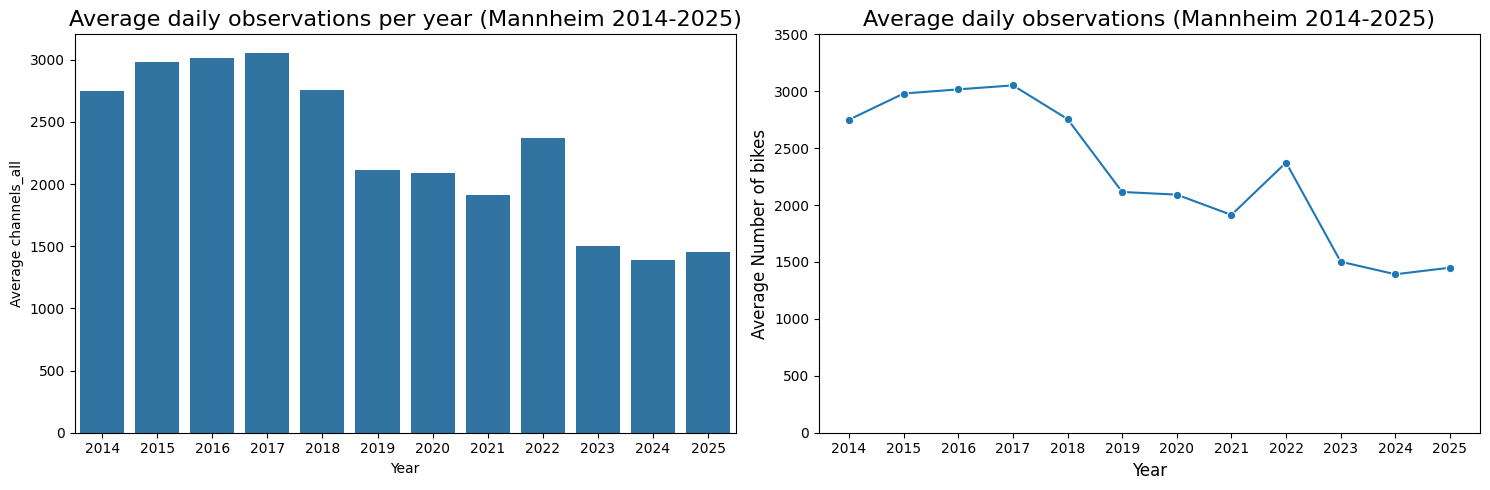

In [7]:
avg_per_year = df_ma.groupby("year")["channels_all"].mean()
years = avg_per_year.index.astype(str)
fig, axs = plt.subplots(1,2, figsize=(15, 5))

sns.barplot(x=years, y=avg_per_year.values, ax=axs[0])
axs[1].set_yticks(range(0, 3501, 500))
axs[0].set_yticklabels(range(0,3501, 500))
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Average channels_all")
axs[0].set_title("Average daily observations per year (Mannheim 2014-2025)", fontsize=16)


# WICHTIG Hier kommt der Abfall des Mittelwerts dadurch, dass mehr Zählstationen hinzugefügt wurden, die nicht an einem Hotspot standen, also Mittelwert sinkt.
plot_data = pd.DataFrame({
    'Year': years,
    'Average': avg_per_year
})

sns.lineplot(x='Year', y='Average', data=plot_data, marker='o', ax=axs[1])
axs[1].set_yticks(range(0, 3501, 500))
axs[1].set_yticklabels(range(0,3501, 500))
axs[1].set_title("Average daily observations (Mannheim 2014-2025)", fontsize=16)
axs[1].set_xlabel("Year", fontsize=12)
axs[1].set_ylabel("Average Number of bikes", fontsize=12)

plt.tight_layout()
plt.show()

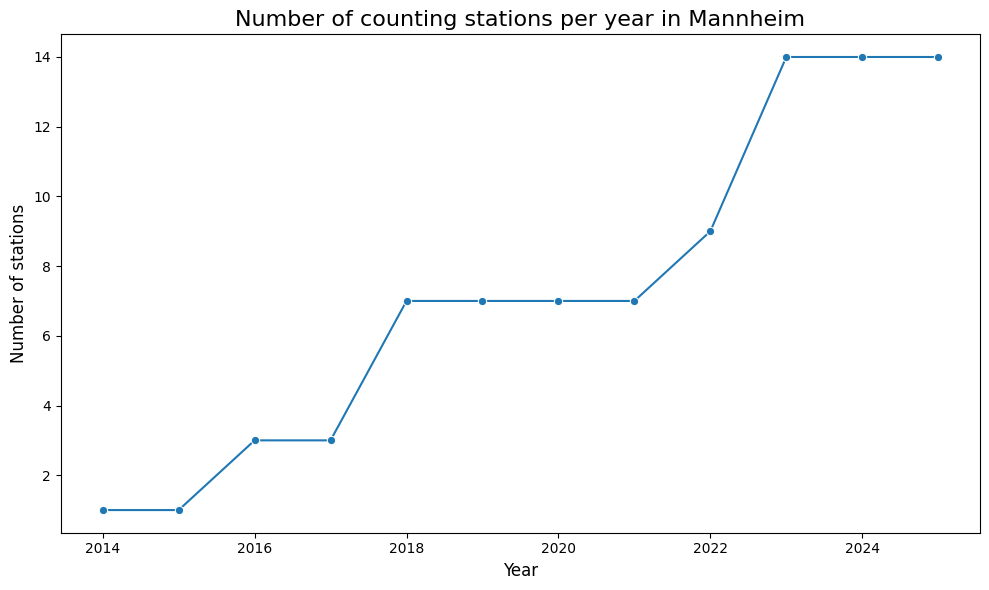

In [8]:
y = df_ma.groupby(by="year")["counter_site"].nunique()
plt.figure(figsize=(10, 6))
sns.lineplot(x=y.index, y=y.values, marker='o')
plt.title("Number of counting stations per year in Mannheim", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of stations", fontsize=12)
plt.tight_layout()
plt.show()


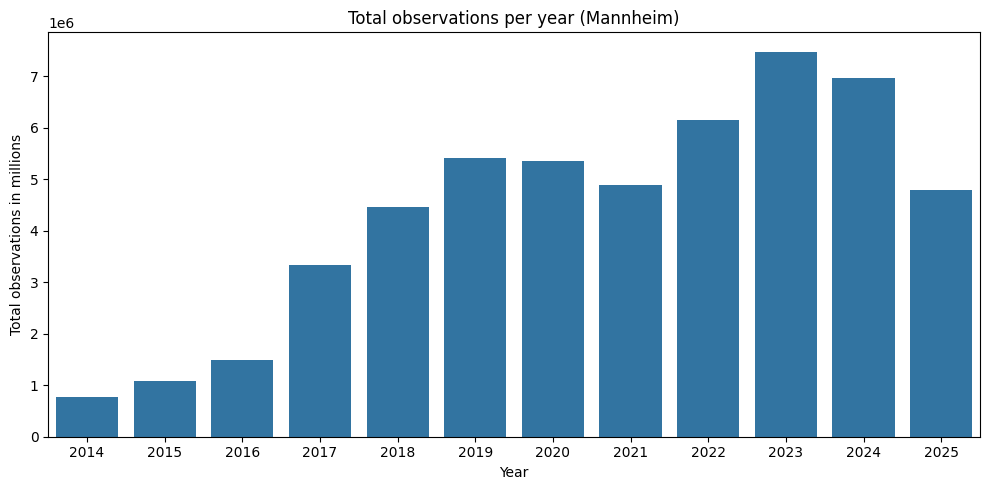

In [9]:
# sollte man das normieren?
sum_per_year = df_ma.groupby("year")["channels_all"].sum()

sum_per_year = sum_per_year.sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=years, y=sum_per_year.values)

plt.xlabel("Year")
plt.ylabel("Total observations in millions")
plt.title("Total observations per year (Mannheim)")
plt.tight_layout()
plt.show()

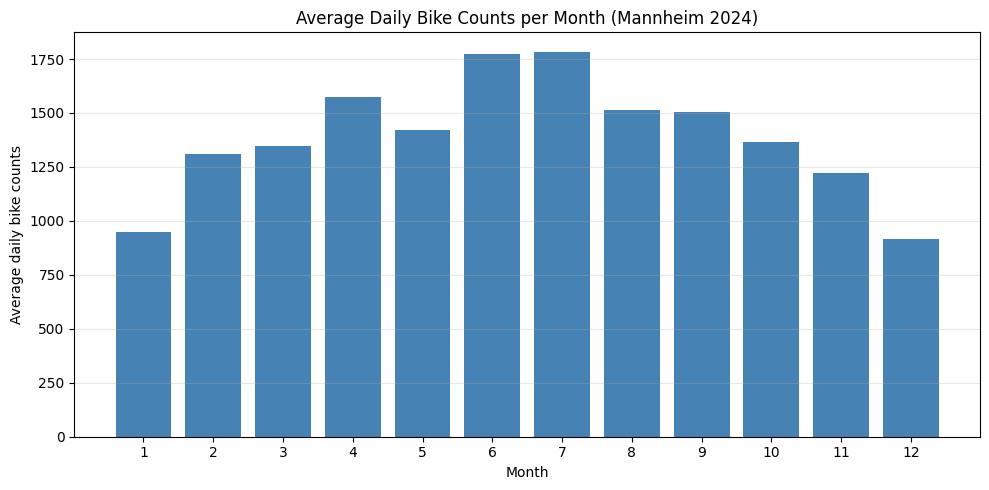

In [10]:
df_ma["timestamp"] = pd.to_datetime(df_ma["iso_timestamp"])
df_ma["year"] = df_ma["timestamp"].dt.year
df_ma["month"] = df_ma["timestamp"].dt.month
df_ma["date"] = df_ma["timestamp"].dt.date

df_2024 = df_ma[df_ma["year"] == 2024].copy()

monthly_avg_2024 = (df_2024.groupby("month")["channels_all"].mean().reset_index())


plt.figure(figsize=(10, 5))
plt.bar( monthly_avg_2024["month"], monthly_avg_2024["channels_all"], color="steelblue" ) 
plt.title("Average Daily Bike Counts per Month (Mannheim 2024)") 
plt.xlabel("Month") 
plt.ylabel("Average daily bike counts") 
plt.xticks(range(1, 13)) 
plt.grid(axis="y", alpha=0.3) 
plt.tight_layout() 
plt.show()


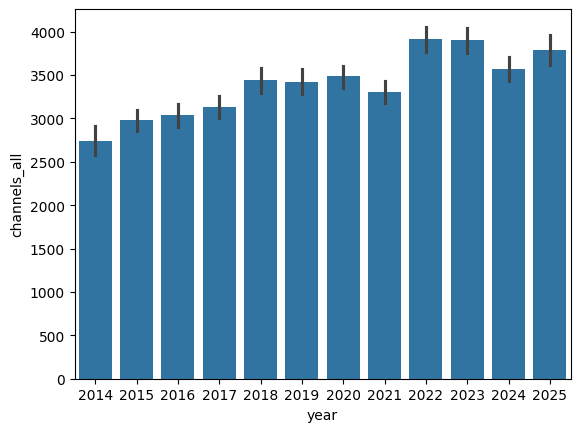

In [11]:
sns.barplot(df_ma[df_ma["counter_site"] == "Renzstraße"],x="year", y="channels_all")
# sns.barplot(df_ma[df_ma["counter_site"] == "Kurpfalzbrücke"],x="year", y="channels_all")
plt.show()

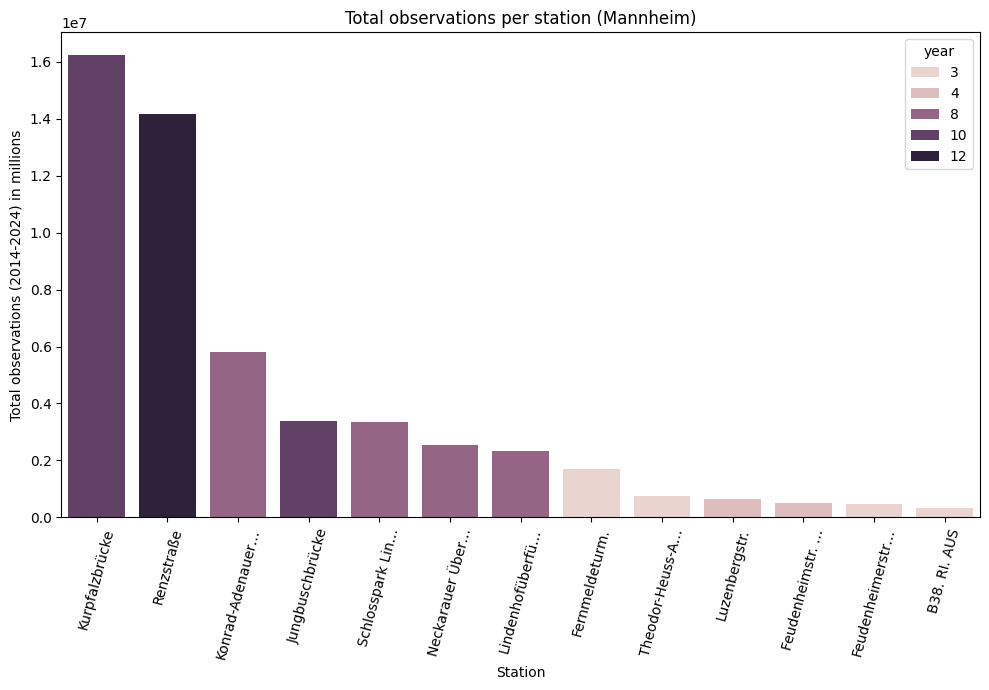

In [12]:
station_sum = df_ma.groupby("short_labels")["channels_all"].sum().sort_values(ascending=False)
year_counts = df_ma.groupby("short_labels")["year"].nunique()
year_counts = year_counts[station_sum.index]  # Reorder year_counts to match the sorted station_sum

plt.figure(figsize=(10, 7))
sns.barplot(x=station_sum.index, y=station_sum.values, hue=year_counts)
plt.xticks(rotation=75)
plt.xlabel("Station")
plt.ylabel("Total observations (2014-2024) in millions")
plt.title("Total observations per station (Mannheim)")
plt.tight_layout()
plt.show()

### Größtes Radverkehrsaufkommen nach Städten

Da die Zählstellen zu unterschiedlichen Zeitpunkten in Betrieb genommen wurden, wurde für vergleichende Analysen ein gemeinsamer Beobachtungszeitraum definiert. Hierzu wurde für jede Zählstelle das erste Jahr mit verfügbaren Messdaten bestimmt. In der Analyse wurden ausschließlich Zählstellen berücksichtigt, die spätestens ab dem Jahr 2018 Daten aufweisen.

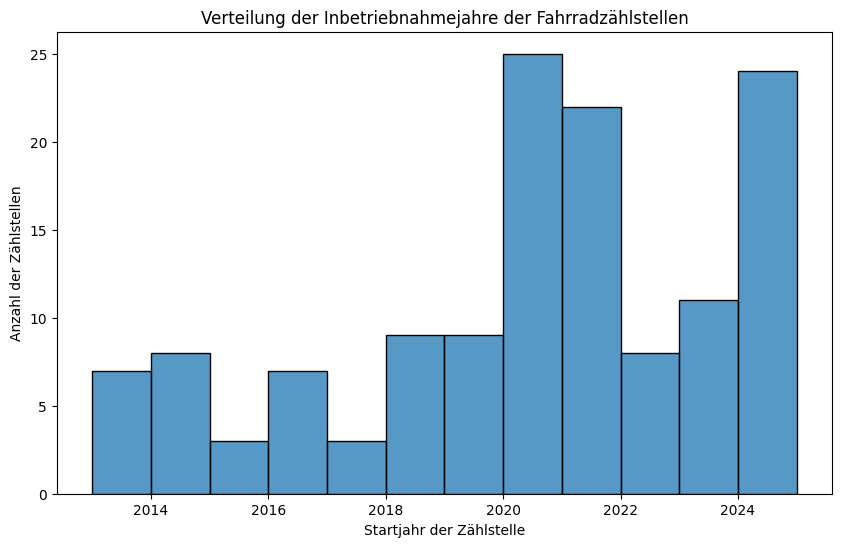

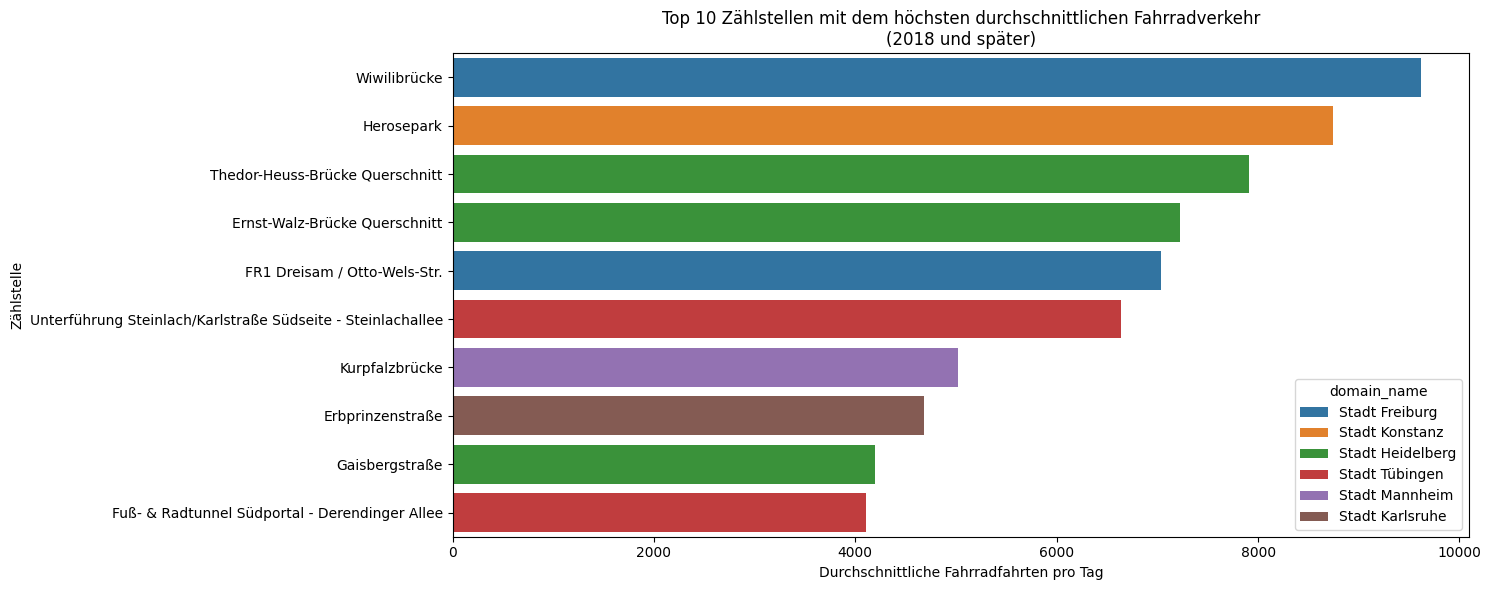

In [13]:
station_coverage = (
    df.groupby("counter_site")
      .agg(
          first_year=("year", "min"),
          last_year=("year", "max"),
          n_observations=("year", "count")
      )
      .reset_index()
)

station_coverage.sort_values("first_year")
valid_stations = station_coverage[
    station_coverage["first_year"] <= 2018
]["counter_site"]

df_common = df[
    (df["counter_site"].isin(valid_stations)) &
    (df["year"] >= 2018)
]
plt.figure(figsize=(10, 6))
sns.histplot(station_coverage["first_year"], bins=range(2013, 2026))
plt.xlabel("Startjahr der Zählstelle")
plt.ylabel("Anzahl der Zählstellen")
plt.title("Verteilung der Inbetriebnahmejahre der Fahrradzählstellen")
plt.show()

# Top 10 Zählstellen
avg_df_common = (
    df_common.groupby(["counter_site", "domain_name"], as_index=False)
      .agg(avg_daily_counts=("channels_all", "mean"))
)

# Top 10 Zählstellen basierend auf dem durchschnittlichen täglichen Fahrradverkehr
top10_common = avg_df_common.sort_values("avg_daily_counts", ascending=False).head(10)

# Visualisierung der Top 10 Zählstellen
plt.figure(figsize=(15, 6))
sns.barplot(
    data=top10_common,
    y="counter_site",
    x="avg_daily_counts",
    hue="domain_name"
)

plt.ylabel("Zählstelle")
plt.xlabel("Durchschnittliche Fahrradfahrten pro Tag")
plt.title("Top 10 Zählstellen mit dem höchsten durchschnittlichen Fahrradverkehr\n(2018 und später)")
plt.tight_layout()
plt.show()

In [ ]:
# TODO welche Station hat den größten Messwertsprung innerhalb eines Jahres erlebt -> woran lag das

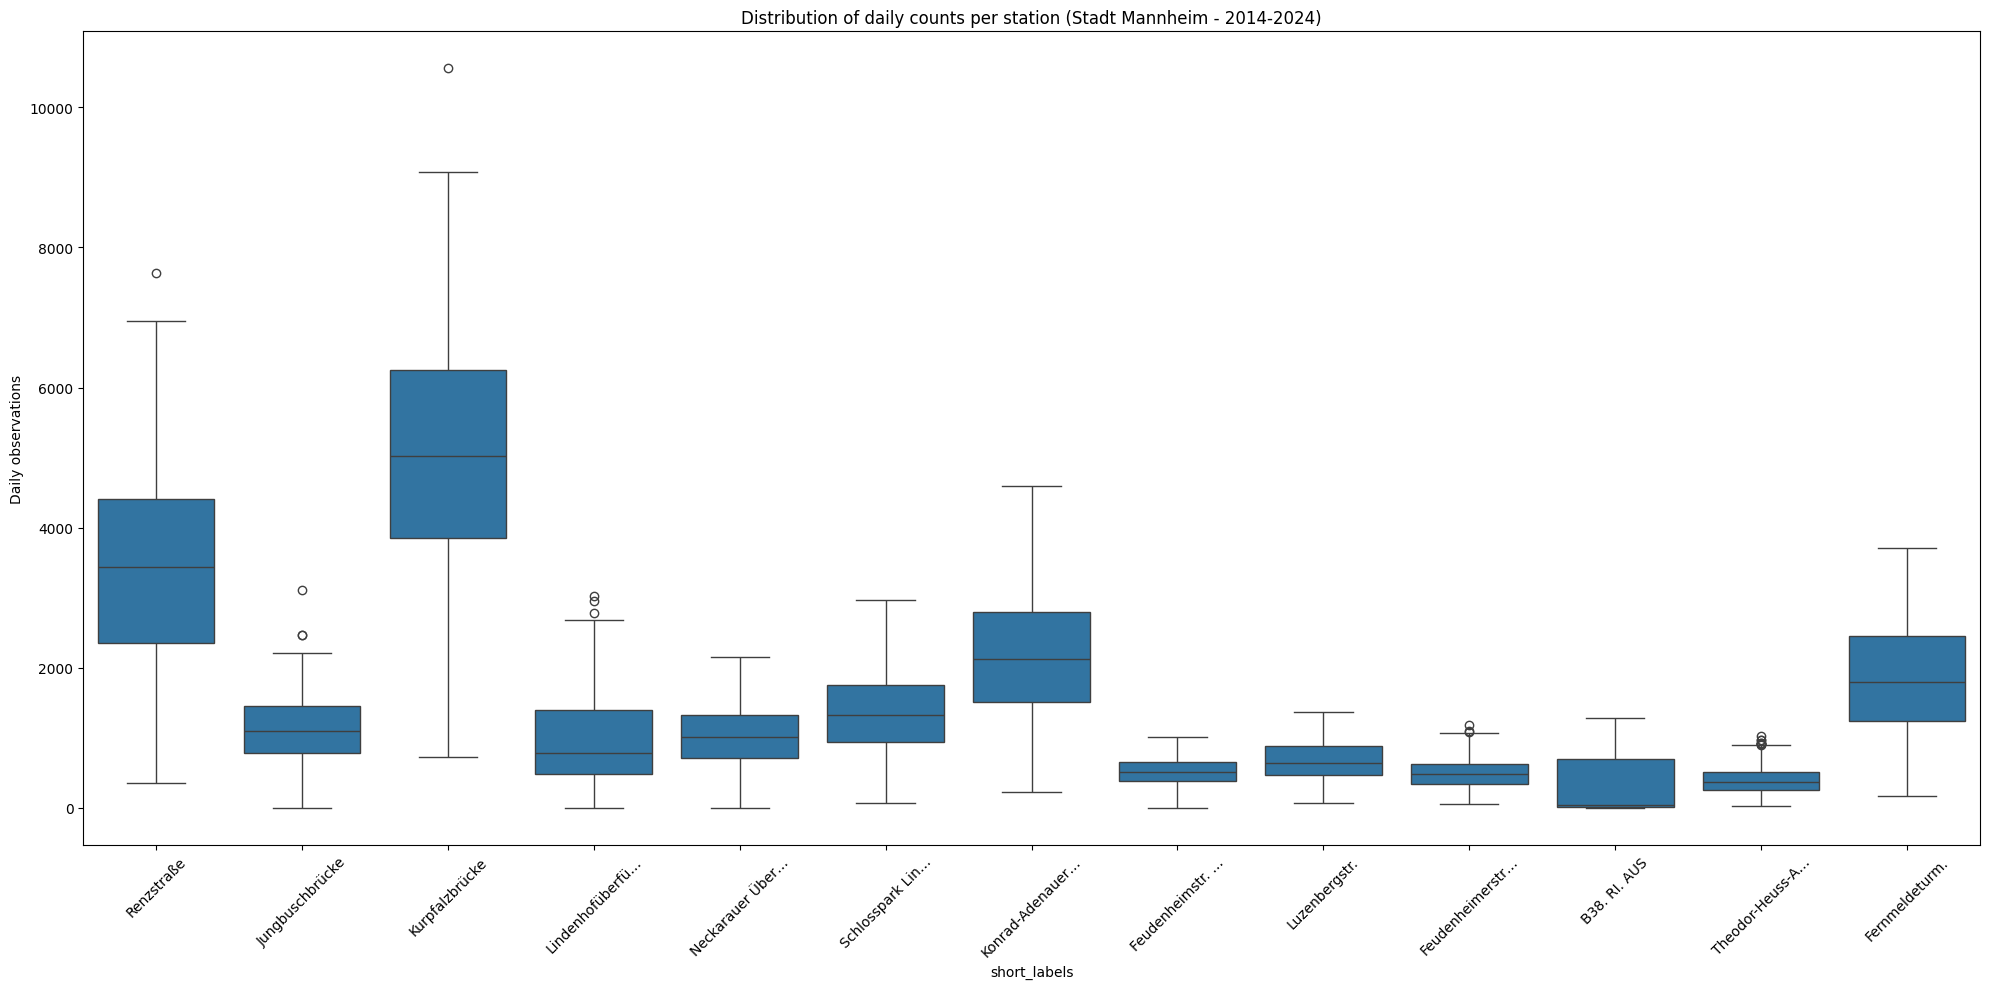

Renzstraße - Höchster Wert:
date            2018-04-10
channels_all          7638
Name: 31964, dtype: object
Kurpfalzbrücke - Höchster Wert:
date            2018-04-10
channels_all         10558
Name: 38023, dtype: object
am 11.04.2018 gab es in Mannheim einen Warnstreik im öffentlichen Dienst und mehrere tausend Menschen nahmen an Demonstrationen teil.
Das erklärt die Ausreißer bei den Fahrradzählungen an diesem Tag.


In [14]:
max_length = 15

plt.figure(figsize=(20, 10))
sns.boxplot(data=df_ma, x="short_labels", y="channels_all")
plt.xticks(rotation=45)
plt.ylabel("Daily observations")
plt.title("Distribution of daily counts per station (Stadt Mannheim - 2014-2024)")
plt.tight_layout()
plt.show()


df["timestamp"] = pd.to_datetime(df_ma["iso_timestamp"])
#Renzstraße
renz = df_ma[df_ma["counter_site"] == "Renzstraße"]
renz_max = renz.loc[renz["channels_all"].idxmax()]
print("Renzstraße - Höchster Wert:")
print(renz_max[["date", "channels_all"]])

#Kurpfalzbrücke
kurp = df_ma[df_ma["counter_site"] == "Kurpfalzbrücke"]
kurp_max = kurp.loc[kurp["channels_all"].idxmax()]
print("Kurpfalzbrücke - Höchster Wert:")
print(kurp_max[["date", "channels_all"]])      

print("am 11.04.2018 gab es in Mannheim einen Warnstreik im öffentlichen Dienst und mehrere tausend Menschen nahmen an Demonstrationen teil.")
print("Das erklärt die Ausreißer bei den Fahrradzählungen an diesem Tag.")

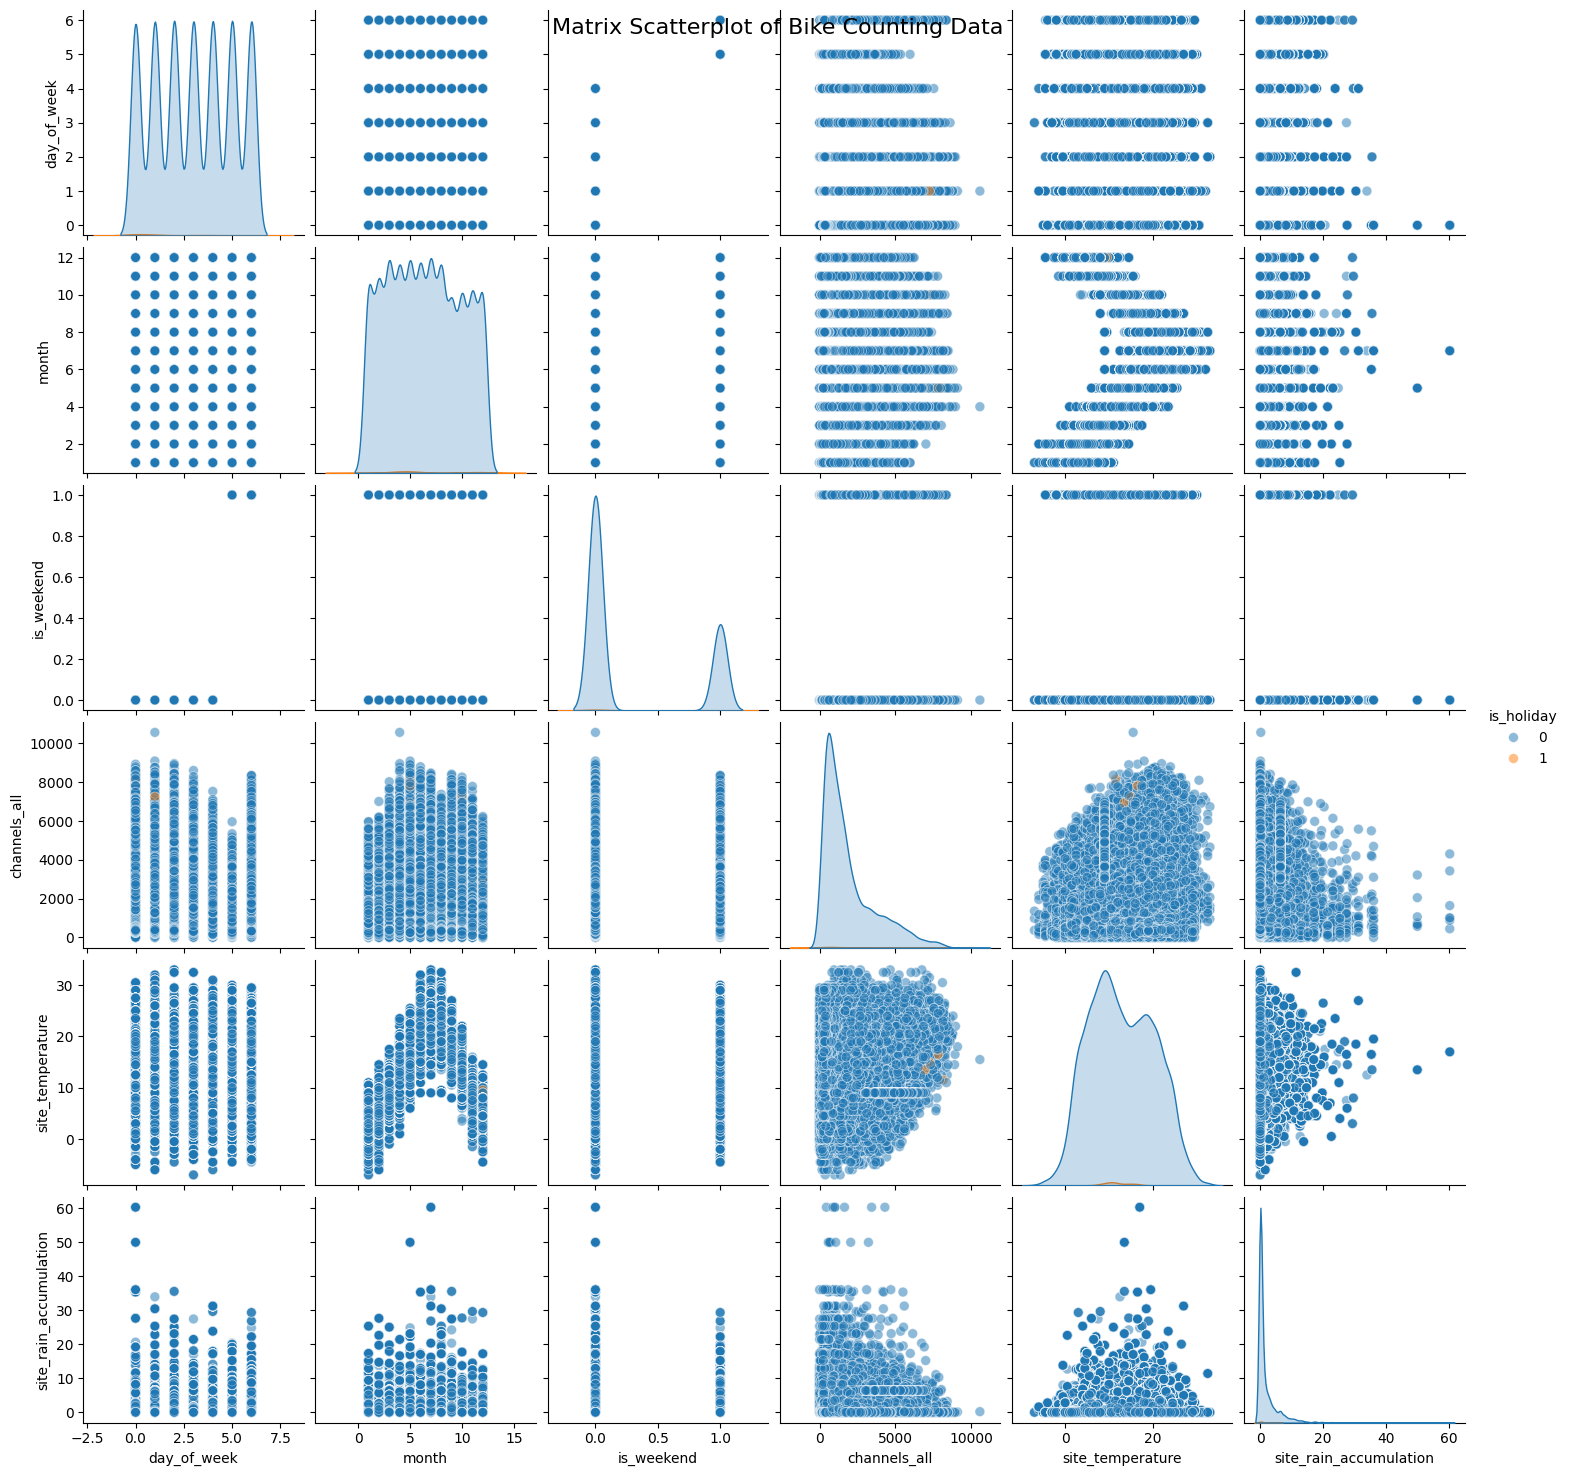

In [15]:
df_ma['day_of_week'] = df_ma['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
df_ma['month'] = df_ma['timestamp'].dt.month
df_ma['is_weekend'] = df_ma['day_of_week'].isin([5, 6]).astype(int)  # 1 if weekend, 0 if weekday
# You can manually add holidays or use a library like `holidays` to check if the day is a public holiday.
de_holidays = holidays.Germany(years=2023)  # For Germany, for example
df_ma['is_holiday'] = df_ma['timestamp'].dt.date.isin(de_holidays.keys()).astype(int)


variables = ['day_of_week','month','is_weekend', 'is_holiday', 'channels_all', 'site_temperature', 'site_rain_accumulation']

# Create the scatterplot matrix using Seaborn's pairplot
sns.pairplot(df_ma[variables], diag_kind='kde', plot_kws={'alpha': 0.5, 's': 50}, hue="is_holiday")

# Customize the plot
plt.suptitle('Matrix Scatterplot of Bike Counting Data', fontsize=16)
plt.show()


In [ ]:
# is_weekend und channels_all vergleichen
sum_weekdays = sum(df_ma[df_ma["is_weekend"]==0]["channels_all"])
sum_weekends = sum(df_ma[df_ma["is_weekend"]==1]["channels_all"])
num_weekdays = len(df_ma[df_ma["is_weekend"]==0])# Since each row is an hour, divide by 24 to get the number of days
num_weekends = len(df_ma[df_ma["is_weekend"]==1])  
avg_weekdays = sum_weekdays / num_weekdays
avg_weekends = sum_weekends / num_weekends



: 

: 

# Korrelation zwischen Temperatur und Fahrradnutzung

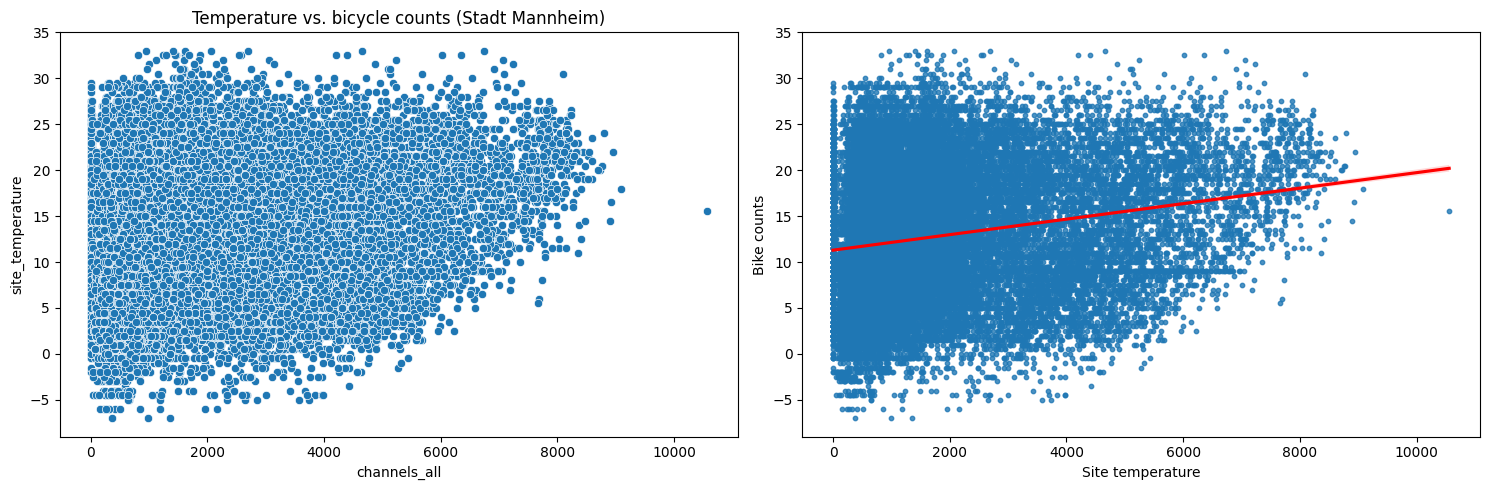

Pearson: 0.202
Spearman: 0.223
Pearson: 0.195
Spearman: 0.272


: 

: 

: 

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15, 5))
sns.scatterplot(data=df_ma, y="site_temperature", x="channels_all", ax=axs[0])
sns.regplot(data=df_ma, y="site_temperature", x="channels_all",scatter_kws={'s': 10}, line_kws={'color': 'red'}, ax=axs[1])
plt.xlabel("Site temperature")
plt.ylabel("Bike counts") 
axs[0].set_title("Temperature vs. bicycle counts (Stadt Mannheim)")
plt.tight_layout()
plt.show()
# Pearson
pearson_ma = df_ma[["channels_all", "site_temperature"]].corr(method="pearson").loc["channels_all", "site_temperature"]

# Spearman
spearman_ma = df_ma[["channels_all", "site_temperature"]].corr(method="spearman").loc["channels_all", "site_temperature"]

print(f"Pearson: {pearson_ma:.3f}")
print(f"Spearman: {spearman_ma:.3f}")

# Drop all nan values in site_temperature from big dataframe
df["site_temperature"] = df["site_temperature"].replace(["na", "NA", "Na"], np.nan)
df = df.dropna(subset=["site_temperature"])
pearson_all = df[["channels_all", "site_temperature"]].corr(method="pearson").loc["channels_all", "site_temperature"]
spearman_all = df[["channels_all", "site_temperature"]].corr(method="spearman").loc["channels_all", "site_temperature"]

print(f"Pearson: {pearson_all:.3f}")
print(f"Spearman: {spearman_all:.3f}")

#### Die insgesamte Korrelation zwischen der Temperatur und der Fahrradnutzung in Mannheim beträgt nach Pearson 0.202.
#### Betrachtet man jedoch die Korrelation der einzelnen der Messstationen so ergeben sich folgende Werte.

                                       counter_site  pearson_corr
1                                      B38. RI. AUS      0.011942
15                             Lindenhofüberführung      0.235979
25                    Theodor-Heuss-Anlage. RI. AUS      0.393459
21                                       Renzstraße      0.445103
19           Neckarauer Übergang -Schwetzinger Str.      0.486533
5                    Feudenheimerstr. stadteinwärts      0.510540
27                    Theodor-Heuss-Anlage. RI. IN.      0.510875
7                      Feudenheimstr. stadtauswärts      0.533080
13                                   Kurpfalzbrücke      0.548310
9                                   Jungbuschbrücke      0.557844
11                           Konrad-Adenauer-Brücke      0.568114
17                                    Luzenbergstr.      0.584917
3                                    Fernmeldeturm.      0.619432
23  Schlosspark Lindenhof (Richtung Jugendherberge)      0.629848


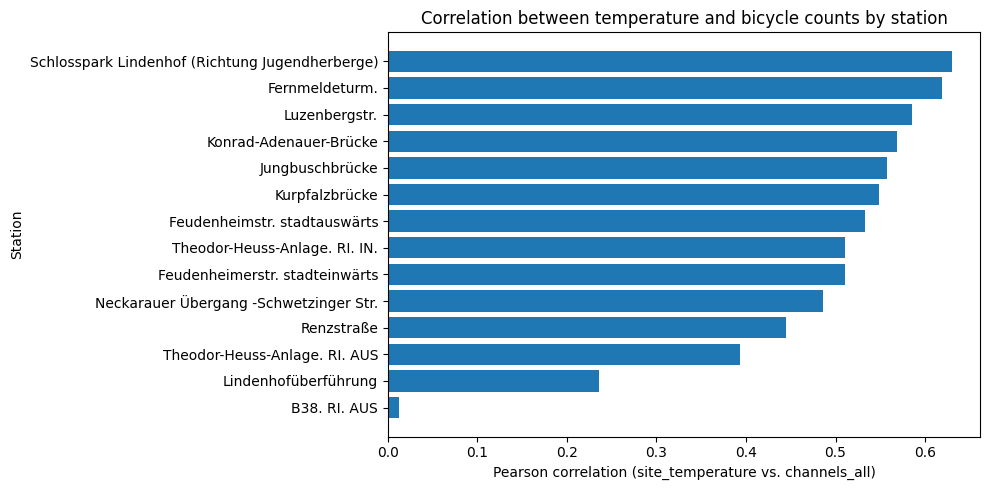

: 

: 

: 

In [ ]:
corr_per_station = (
    df_ma.groupby("counter_site")[["channels_all", "site_temperature"]]
         .corr(method="pearson")
         .reset_index()
)

# Nur die Zeilen channels_all vs. site_temperature extrahieren
corr_per_station = corr_per_station[
    (corr_per_station["level_1"] == "site_temperature") &
    (corr_per_station["counter_site"].notna())
][["counter_site", "channels_all"]].rename(columns={"channels_all": "pearson_corr"})

print(corr_per_station.sort_values("pearson_corr"))

corr_per_station_sorted = corr_per_station.sort_values("pearson_corr")

plt.figure(figsize=(10, 5))
plt.barh(corr_per_station_sorted["counter_site"], corr_per_station_sorted["pearson_corr"])
plt.xlabel("Pearson correlation (site_temperature vs. channels_all)")
plt.ylabel("Station")
plt.title("Correlation between temperature and bicycle counts by station")
plt.tight_layout()
plt.show()

An den meisten Stationen ist die Korrelation positiv (d.h. wärmere Tage → mehr Radverkehr).“
„Die Stärke variiert jedoch deutlich zwischen den Stationen (von ~0 bis ~0.63).“
„Insbesondere an Stationen X, Y, Z ist der Zusammenhang besonders stark.“

/tmp/ipykernel_148243/3267416270.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot( data=df_ma, x="rain_category", y="channels_all",palette="Blues", legend = False, ax=axs[1])


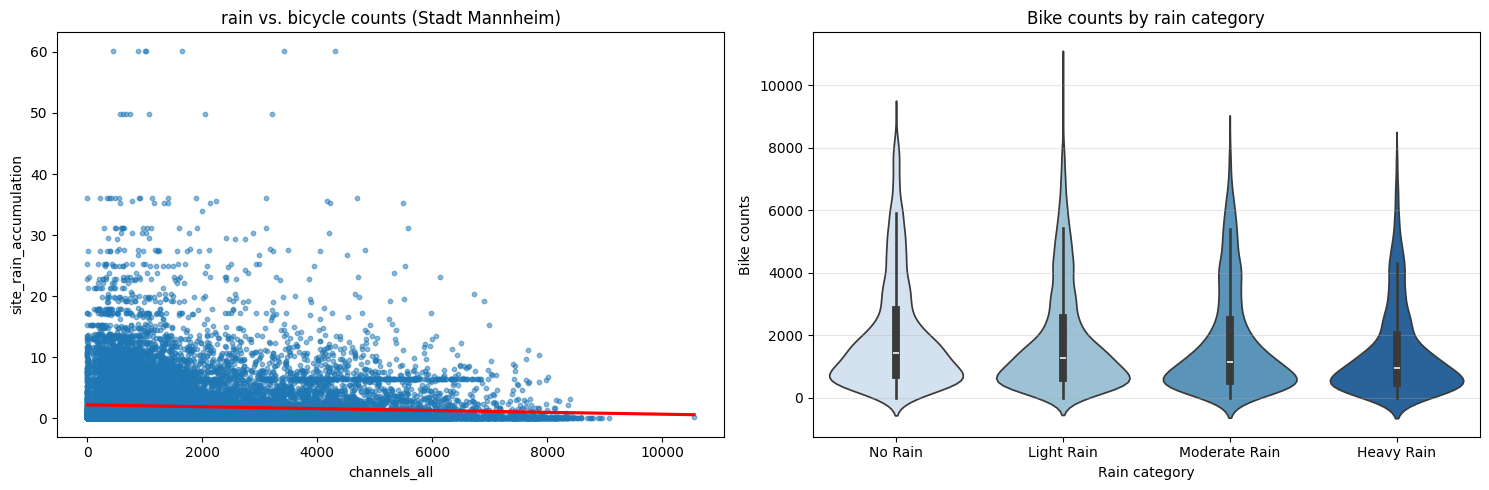

Spearman (Mannheim): -0.100
Spearman (alle Städte): -0.114


: 

: 

: 

In [ ]:
#rain category
df_ma["rain_category"] = pd.cut(df_ma["site_rain_accumulation"], bins=[-0.1, 0, 2.5, 7.6, 50], labels=["No Rain", "Light Rain", "Moderate Rain", "Heavy Rain"]) 

fig, axs = plt.subplots(1,2,figsize=(15, 5))


sns.regplot(data=df_ma, y="site_rain_accumulation", x="channels_all",scatter_kws={'s': 10, 'alpha':0.5}, line_kws={'color': 'red'}, ax=axs[0])

plt.xlabel("rain accumulation")
plt.ylabel("bike counts") 
axs[0].set_title("rain vs. bicycle counts (Stadt Mannheim)")
plt.tight_layout()

sns.violinplot( data=df_ma, x="rain_category", y="channels_all",palette="Blues", legend = False, ax=axs[1]) 
axs[1].set_title("Bike counts by rain category") 
axs[1].set_xlabel("Rain category") 
axs[1].set_ylabel("Bike counts") 
axs[1].grid(axis="y", alpha=0.3)
plt.tight_layout() 
plt.show()

# Spearman
spearman_ma = ( df_ma[["channels_all", "site_rain_accumulation"]] .corr(method="spearman") .loc["channels_all", "site_rain_accumulation"] ) 
print(f"Spearman (Mannheim): {spearman_ma:.3f}") 
# Gesamtdaten bereinigen 
df["site_rain_accumulation"] = df["site_rain_accumulation"].replace(["na", "NA", "Na"], np.nan) 
df = df.dropna(subset=["site_rain_accumulation"]) 
spearman_all = ( df[["channels_all", "site_rain_accumulation"]].corr(method="spearman").loc["channels_all", "site_rain_accumulation"] ) 
print(f"Spearman (alle Städte): {spearman_all:.3f}")

{2020: np.int64(1688124), 2021: np.int64(1525185), 2022: np.int64(1789267), 2023: np.int64(2262742)} 2022 vs 2021 %: 17.31475198090724 2022 vs 2023 %: -20.924833675248877


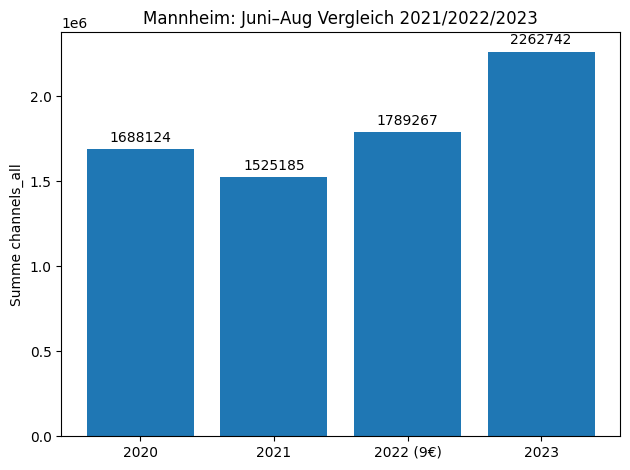

In [34]:
#Auswirkung df_maer Einführung df_maes 9-Euro-Tickets vom 1. Juni 2022 bis zum 31. August 2022 im Vergleich zum Jahr df_maavor undf_ma df_maanach

#In Mannheim

df_ma["t"] = pd.to_datetime(df_ma["iso_timestamp"].astype(str).str.strip(), errors="coerce", utc=True)
df_ma = df_ma.dropna(subset=["t"])


df_ma["metric"] = pd.to_numeric(df_ma["channels_all"], errors="coerce") 

def win_sum(y):
    a = pd.Timestamp(f"{y}-06-01", tz="Europe/Berlin")
    b = pd.Timestamp(f"{y}-09-01", tz="Europe/Berlin")
    return df_ma.loc[(df_ma["t"]>=a) & (df_ma["t"]<b), "metric"].sum(skipna=True)

vals = {y: win_sum(y) for y in [2020, 2021, 2022, 2023]}
print(vals, "2022 vs 2021 %:", (vals[2022]/vals[2021]-1)*100, "2022 vs 2023 %:", (vals[2022]/vals[2023]-1)*100)

fig, ax = plt.subplots()
bars = ax.bar(["2020", "2021","2022 (9€)","2023"], [vals[2020], vals[2021], vals[2022], vals[2023]])
ax.bar_label(bars, padding=3, fmt="%.0f")
ax.set_title("Mannheim: Juni–Aug Vergleich 2021/2022/2023")
ax.set_ylabel("Summe channels_all")
plt.tight_layout()
plt.show()




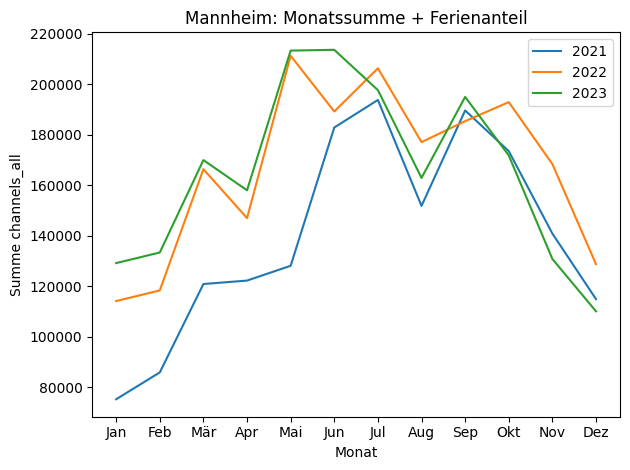

In [28]:
# Monatliche Beobachtungen im Jahr 2021, 2022, 2023 in Mannheim als Liniendiagramm

years  = [2021, 2022, 2023]
labels = ["Jan","Feb","Mär","Apr","Mai","Jun","Jul","Aug","Sep","Okt","Nov","Dez"]

# --- 1) vorbereiten + filtern ---
d = df_backup.copy()
d["t"] = (pd.to_datetime(d["iso_timestamp"], errors="coerce", utc=True)
            .dt.tz_convert("Europe/Berlin"))
d = d[
    (d["domain_name"].astype(str).str.strip() == "Stadt Mannheim") &
    (d["counter_site"].astype(str).str.strip() == "Kurpfalzbrücke") &
    d["t"].notna()
]
d["metric"] = pd.to_numeric(d["channels_all"], errors="coerce").fillna(0)

# --- 2) Tageswerte -> Monatssummen je Jahr ---
daily = d.groupby(d["t"].dt.floor("D"))["metric"].sum().reset_index(name="metric")
daily["year"]  = daily["t"].dt.year
daily["month"] = daily["t"].dt.month
daily = daily[daily["year"].isin(years)]

m = daily.groupby(["year", "month"])["metric"].sum().reset_index(name="month_sum")

# Pivot für Plot (Monate 1..12 als Index, Jahre als Spalten)
sum_pivot = (m.pivot(index="month", columns="year", values="month_sum")
               .reindex(range(1, 13), fill_value=0))


# --- Ferien markieren (Tagesebene) ---
def build_ferien_bw(years):
    same_year  = [("04-19","04-24"), ("06-07","06-19"), ("07-28","09-11"), ("11-02","11-05")]
    cross_year = [("12-21","01-08")]
    out = []
    for y in years:
        out += [(f"{y}-{s}", f"{y}-{e}") for s,e in same_year]
        out += [(f"{y}-{s}", f"{y+1}-{e}") for s,e in cross_year]
    return out

ferien = [(pd.Timestamp(s, tz="Europe/Berlin"), pd.Timestamp(e, tz="Europe/Berlin"))
          for s, e in build_ferien_bw(years)]

daily = d.groupby(d["t"].dt.floor("D"))["metric"].sum().reset_index(name="metric")
daily["year"]  = daily["t"].dt.year
daily["month"] = daily["t"].dt.month
daily = daily[daily["year"].isin(years)]

daily["is_holiday"] = False
for s, e in ferien:
    daily.loc[(daily["t"] >= s) & (daily["t"] < e), "is_holiday"] = True

m = (daily.groupby(["year","month"])
          .agg(month_sum=("metric","sum"),
               holiday_share=("is_holiday","mean"))  # Anteil Ferientage im Monat
          .reset_index())

sum_pivot = (m.pivot(index="month", columns="year", values="month_sum")
               .reindex(range(1,13), fill_value=0))
hol_pivot = (m.pivot(index="month", columns="year", values="holiday_share")
               .reindex(range(1,13), fill_value=0))


x = np.arange(1, 13)
fig, ax = plt.subplots()

for y in years:
    ax.plot(x, sum_pivot[y].to_numpy(), label=str(y))


ax.set_xticks(x, labels)
ax.set_xlabel("Monat")
ax.set_ylabel("Summe channels_all")
ax.set_title("Mannheim: Monatssumme + Ferienanteil")
ax.legend()
plt.tight_layout()
plt.show()

# Prognose berechnen für Wachstum im Jahr 2022 mit bezug ob das 9$ Ticket gedämpft hat